In [215]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import graph_tool as gt
from graph_tool import draw, centrality, clustering, topology
import pandas as pd
import numpy as np
import scipy
import json

## Загрузка графа

In [216]:
df = pd.read_csv('data/graph.csv', header=0)
df.head()

,person1,person2,years_worked_together
0,8,9,8
1,8,10,7
2,8,11,4
3,8,12,8
4,8,13,8


In [217]:
df.shape

(4374346, 3)

In [218]:
df[df.columns[2]].describe()

count    4.374346e+06
mean     1.357308e+00
std      8.466583e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      8.000000e+00
Name: years_worked_together, dtype: float64

In [219]:
THRESHOLD = 2

df = df[df[df.columns[2]] >= THRESHOLD]

In [220]:
df.shape

(986696, 3)

In [221]:
def create_mapping(edges):
    mapping = {}
    mapping_reverse = {}
    mapped_edges = []
    
    i = 0
    for edge in edges:
        for v in edge:
            if v not in mapping:
                mapping[v] = i
                mapping_reverse[i] = v
                i += 1
        mapped_edges.append((mapping[edge[0]], mapping[edge[1]]))
    
    return mapped_edges, mapping, mapping_reverse

In [222]:
edges = [tuple(x) for x in df.iloc[:,:2].values]
weights = df.iloc[:,2].tolist()

In [223]:
# edges

In [224]:
# weights

In [225]:
mapped_edges, mapping, mapping_reverse = create_mapping(edges)

In [226]:
# mapping, mapping_reverse

In [227]:
# mapped_edges

In [228]:
g = gt.Graph(directed=False)
e_weight = g.new_edge_property("float")

In [229]:
g.add_edge_list(mapped_edges)
e_weight.a = weights

In [230]:
g.num_vertices()

17568

## Визуализация

In [231]:
pos = gt.draw.sfdp_layout(g, verbose=True, max_iter=10)

Coarse level (EC): 2  num vertices: 9005
Coarse level (EC): 3  num vertices: 4704
Coarse level (EC): 4  num vertices: 2555
Coarse level (EC): 5  num vertices: 1489
Coarse level (EC): 6  num vertices: 951
Coarse level (EC): 7  num vertices: 687
Coarse level (MIVS): 8  num vertices: 585
Coarse level (MIVS): 9  num vertices: 449
Positioning level: 0 449 with K = 13.058653870278826 ...
avg edge distance: 17.364263455370608
propagating... 449
Positioning level: 1 585 with K = 9.79399040270912 ...
avg edge distance: 13.495621254479397
propagating... 
Positioning level: 2 687 with K = 7.34549280203184 ...
avg edge distance: 9.97217545899485
propagating... 
Positioning level: 3 951 with K = 5.50911960152388 ...
avg edge distance: 7.435780698698145
propagating... 
Positioning level: 4 1489 with K = 4.13183970114291 ...
avg edge distance: 5.521352549019874
propagating... 
Positioning level: 5 2555 with K = 3.0988797758571827 ...
avg edge distance: 4.154607965339367
propagating... 
Positioning le

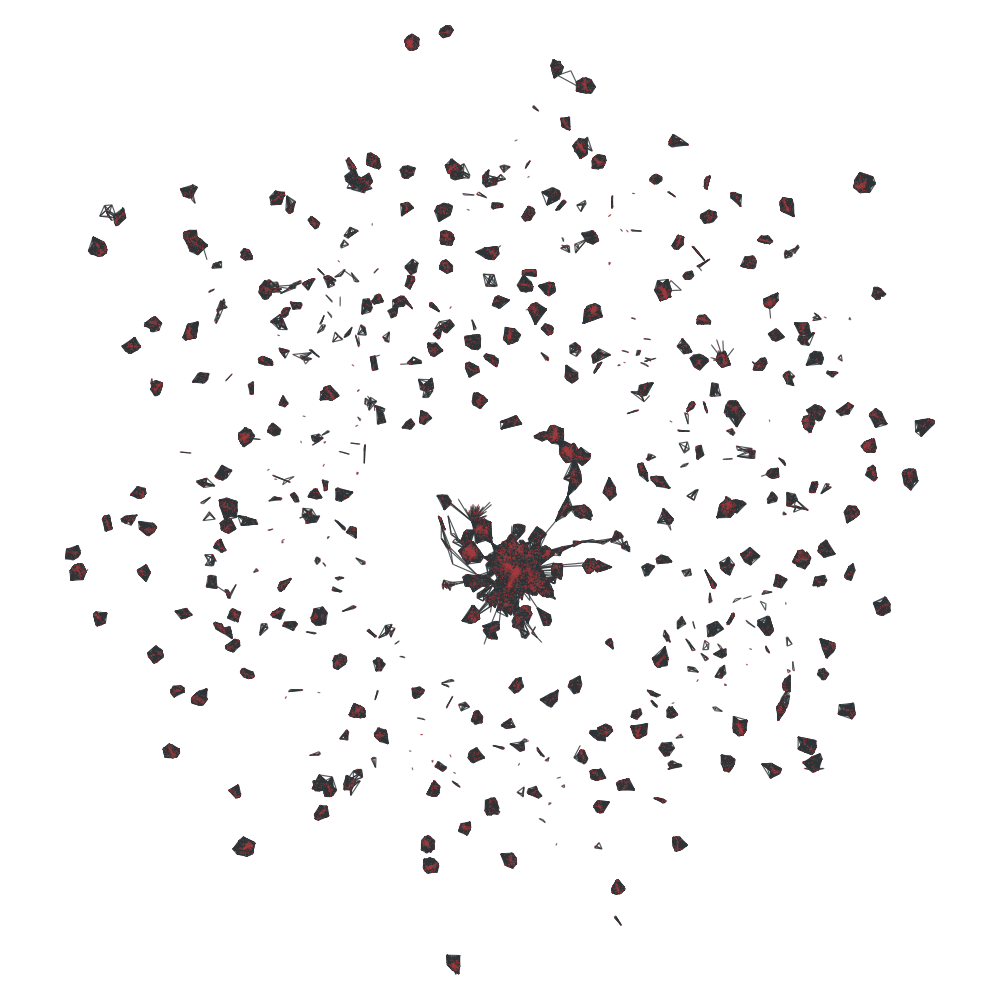

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fcf6b995278, at 0x7fcf4fd939e8>

In [232]:
gt.draw.graph_draw(g, pos, output_size=(1000, 1000), vertex_size=1, edge_pen_width=1.2, vcmap=matplotlib.cm.gist_heat_r)

## Анализ графа

In [233]:
print('Order: {}, size: {}'.format(g.num_vertices(), g.num_edges()))

Order: 17568, size: 986696


In [234]:
comp, comp_hist = gt.topology.label_components(g)

In [235]:
n_comp = len(comp_hist)
print('Number of Connected Components: {}'.format(n_comp))

Number of Connected Components: 429


In [236]:
sorted(comp_hist, reverse=True)[:10]

[5133, 243, 210, 203, 198, 190, 173, 166, 153, 138]

In [237]:
gc_index = np.argmax(comp_hist)
gc = gt.GraphView(g, vfilt=comp.a == gc_index)

In [238]:
print('Greatest Connected Component - Order: {}, size: {}'.format(gc.num_vertices(), gc.num_edges()))

Greatest Connected Component - Order: 5133, size: 575640


Coarse level (EC): 2  num vertices: 2643
Coarse level (EC): 3  num vertices: 1383
Coarse level (EC): 4  num vertices: 750
Coarse level (EC): 5  num vertices: 429
Coarse level (EC): 6  num vertices: 265
Coarse level (EC): 7  num vertices: 181
Coarse level (EC): 8  num vertices: 135
Coarse level (MIVS): 9  num vertices: 110
Coarse level (MIVS): 10  num vertices: 14
Coarse level (MIVS): 11  num vertices: 4
Positioning level: 0 4 with K = 0.7353542977132045 ...
avg edge distance: 0.6333587270584058
propagating... 4
Positioning level: 1 14 with K = 0.5515157232849034 ...
avg edge distance: 0.5940436789829886
propagating... 14
Positioning level: 2 110 with K = 0.41363679246367757 ...
avg edge distance: 0.6019129650454481
propagating... 
Positioning level: 3 135 with K = 0.31022759434775815 ...
avg edge distance: 0.6752859241931766
propagating... 
Positioning level: 4 181 with K = 0.2326706957608186 ...
avg edge distance: 0.5341615763359029
propagating... 
Positioning level: 5 265 with K = 0.

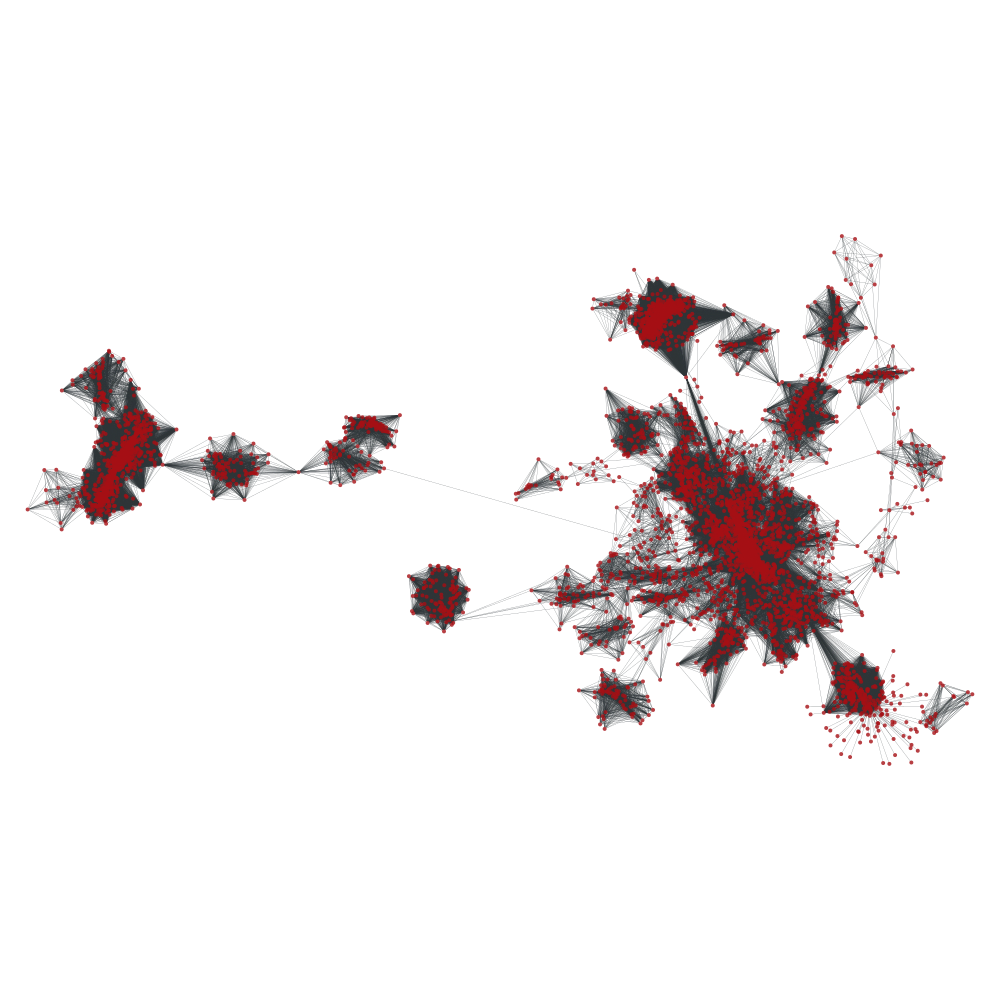

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fcf4fd93e80, at 0x7fcf6b990d30>

In [239]:
pos_gc = gt.draw.sfdp_layout(gc, verbose=True, max_iter=10)
gt.draw.graph_draw(gc, pos_gc, output_size=(1000, 1000), vcmap=matplotlib.cm.gist_heat_r,
           edge_pen_width=0.2, vertex_color=[1,1,1,0])

In [240]:
deg = g.degree_property_map('total').a

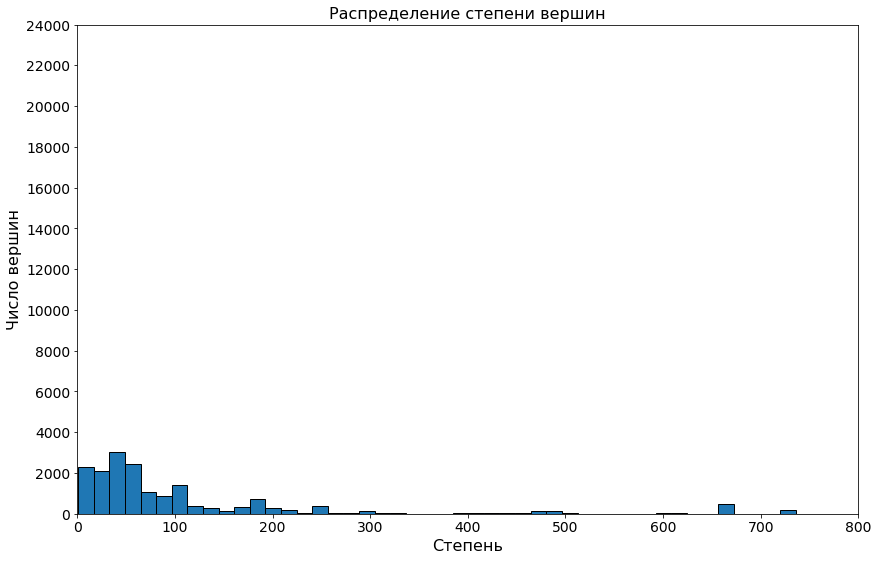

In [241]:
plt.figure(figsize=(14, 9))
plt.hist(deg, ec='black', bins=50)
plt.xticks([i * 100 for i in range(21)], fontsize=14)
plt.yticks([i * 1000 for i in range(0, 31, 2)], fontsize=14)
plt.xlim(0, max(deg))
plt.ylim(0, 24000)
plt.xlabel('Степень', fontsize=16)
plt.ylabel('Число вершин', fontsize=16)
plt.title('Распределение степени вершин', fontsize=16)
plt.show()

In [242]:
diameter = gt.topology.pseudo_diameter(gc)[0]
clustering = gt.clustering.global_clustering(gc)[0]

In [243]:
print('Diameter: {}, Clustering Coefficient: {:.2f}'.format(diameter, clustering))

Diameter: 21.0, Clustering Coefficient: 0.93


In [244]:
# sample_amount = len(list(gc.vertices()))*10
# print(sample_amount)
# pairs_subsample = np.random.choice(list(gc.vertices()), (sample_amount, 2))

In [245]:
# shortest_paths = []

# for pair in pairs_subsample:
#     shortest_paths.append(gt.topology.shortest_distance(gc, source=pair[0], target=pair[1]))

In [246]:
# len(shortest_paths)

In [247]:
# plt.figure(figsize=(14, 9))
# plt.hist(shortest_paths, ec='black', bins=20)
# plt.xlabel('Длина кратчайшего пути', fontsize=16)
# plt.ylabel('Число пар', fontsize=16)
# plt.xticks([i for i in range(17)], fontsize=14)
# plt.yticks([i * 1000 for i in range(0, 31, 2)], fontsize=14)
# plt.title('Распределение длины кратчайшего пути', fontsize=16)
# plt.show()

In [248]:
# Report
print('Order: {}, size: {}'.format(g.num_vertices(), g.num_edges()))
print('Greatest Connected Component - Order: {}, size: {}'.format(gc.num_vertices(), gc.num_edges()))
print('Diameter: {}, Clustering Coefficient: {:.2f}'.format(diameter, clustering))

Order: 17568, size: 986696
Greatest Connected Component - Order: 5133, size: 575640
Diameter: 21.0, Clustering Coefficient: 0.93


## Центральности

In [249]:
def centr_to_json(centr, mapping_reverse, name):
    res = {}
    for i, v in enumerate(centr):
        res[mapping_reverse[i]] = v
        
    with open('data/{}_centrality.json'.format(name), 'w') as out_file:
        tmp = {str(k): round(res[k], 3) for k in res}
        json.dump(tmp, out_file)
    
    return res

### Degree

In [250]:
deg_centr = deg / (len(deg) - 1)

In [251]:
deg_centr_dict = centr_to_json(deg_centr, mapping_reverse, 'degree')

In [252]:
deg_centr_df = pd.DataFrame.from_dict(deg_centr_dict, orient='index').reset_index()
deg_centr_df.columns= ['person_id', 'degree_centrality']
deg_centr_df.head()

,person_id,degree_centrality
0,8,0.035009
1,9,0.035009
2,10,0.034383
3,11,0.031764
4,12,0.035009


### Betweenness

In [253]:
1

1

In [254]:
vertex_betw, edge_betw = gt.centrality.betweenness(g)

In [255]:
betw_centr = vertex_betw.a

In [256]:
betw_centr_dict = centr_to_json(betw_centr, mapping_reverse, 'betweenness')

In [257]:
betw_centr_df = pd.DataFrame.from_dict(betw_centr_dict, orient='index').reset_index()
betw_centr_df.columns= ['person_id', 'betw_centrality']
betw_centr_df.head()

,person_id,betw_centrality
0,8,0.000158
1,9,0.000158
2,10,0.000129
3,11,0.000039
4,12,0.000158


### Pagerank

In [258]:
pagerank = gt.centrality.pagerank(g)

In [259]:
pagerank_centr = pagerank.a

In [260]:
pagerank_centr_dict = centr_to_json(pagerank_centr, mapping_reverse, 'pagerank')

In [261]:
1

1

In [262]:
pagerank_centr_df = pd.DataFrame.from_dict(pagerank_centr_dict, orient='index').reset_index()
pagerank_centr_df.columns= ['person_id', 'pagerank_centrality']
pagerank_centr_df.head()

,person_id,pagerank_centrality
0,8,0.000093
1,9,0.000093
2,10,0.000091
3,11,0.000085
4,12,0.000093


### Closeness

In [263]:
closeness = gt.centrality.closeness(g)

In [264]:
closeness_centr = closeness.a

In [265]:
closeness_centr_dict = centr_to_json(closeness_centr, mapping_reverse, 'closeness')

In [266]:
closeness_centr_df = pd.DataFrame.from_dict(closeness_centr_dict, orient='index').reset_index()
closeness_centr_df.columns= ['person_id', 'closeness_centrality']
closeness_centr_df.head()

,person_id,closeness_centrality
0,8,0.284353
1,9,0.284353
2,10,0.283082
3,11,0.267375
4,12,0.284353


## Корреляция дохода и центральностей

In [267]:
# with open('data/officials.json') as inp_file:
#     officials_dict = json.load(inp_file)

In [268]:
declarations_df = pd.read_csv('data/declarations_clean.csv')
declarations_df.head()

,document_type,party,person_id,person_name,year,office_id,office_name,office_post,office_type_id,office_type_name,office_region_id,office_region_name,income_personal,income_relatives,savings,real_estate_amount,real_estate_squares,income
0,антикоррупционная декларация,кпрф,8,зюганов геннадий андреевич,2009,14,государственная дума,член комитета государственной думы,7,федеральный без региональной структуры,NaN,NaN,2075542.33,102279.19,0.0,3,448.7,2177821.52
1,антикоррупционная декларация,кпрф,8,зюганов геннадий андреевич,2010,14,государственная дума,член комитетa государственной думы,7,федеральный без региональной структуры,NaN,NaN,2127686.49,168601.94,0.0,3,448.7,2296288.43
2,антикоррупционная декларация,кпрф,8,зюганов геннадий андреевич,2011,14,государственная дума,NaN,7,федеральный без региональной структуры,NaN,NaN,2177566.64,137656.24,0.0,3,448.7,2315222.88
3,антикоррупционная декларация,кпрф,8,зюганов геннадий андреевич,2012,14,государственная дума,член комитета гд по науке и наукоемким техноло...,7,федеральный без региональной структуры,NaN,NaN,2458749.04,194266.38,0.0,3,448.7,2653015.42
4,антикоррупционная декларация,кпрф,8,зюганов геннадий андреевич,2013,14,государственная дума,член комитета государственной думы,7,федеральный без региональной структуры,NaN,NaN,3194615.67,198267.22,0.0,3,448.7,3392882.89


In [269]:
officials_df = declarations_df.groupby(['person_id', 'person_name']).income.sum().dropna().reset_index()
officials_df.head()

,person_id,person_name,income
0,8,зюганов геннадий андреевич,2.989557e+07
1,9,алферов жорес иванович,1.344564e+08
2,10,андреев андрей анатольевич,2.923809e+07
3,11,апарина алевтина викторовна,9.210708e+06
4,12,афонин юрий вячеславович,4.928650e+07


In [270]:
# officials_df = pd.DataFrame.from_dict(officials_dict, orient='index').reset_index()
# officials_df.columns = ['person_id', 'person_name', 'income']
# officials_df['person_id'] = officials_df['person_id'].astype(int)
# officials_df['person_id'] = officials_df['person_id'].map(mapping)
# officials_df = officials_df.dropna()
# officials_df['person_id'] = officials_df['person_id'].astype(int)
# officials_df.head()

In [271]:
# officials_df = officials_df.sort_values(by='person_id').reset_index(drop=True)
# officials_df.head()

In [272]:
# mapping_reverse

In [273]:
# officials_centr_df = officials_df.merge(deg_centr_df, how='left', on='person_id')
officials_centr_df = officials_df.merge(betw_centr_df, how='left', on='person_id')
officials_centr_df = officials_centr_df.merge(closeness_centr_df, how='left', on='person_id')
officials_centr_df = officials_centr_df.merge(pagerank_centr_df, how='left', on='person_id')
officials_centr_df.head()

,person_id,person_name,income,betw_centrality,closeness_centrality,pagerank_centrality
0,8,зюганов геннадий андреевич,2.989557e+07,0.000158,0.284353,0.000093
1,9,алферов жорес иванович,1.344564e+08,0.000158,0.284353,0.000093
2,10,андреев андрей анатольевич,2.923809e+07,0.000129,0.283082,0.000091
3,11,апарина алевтина викторовна,9.210708e+06,0.000039,0.267375,0.000085
4,12,афонин юрий вячеславович,4.928650e+07,0.000158,0.284353,0.000093


In [274]:
officials_centr_df.shape

(41551, 6)

In [275]:
officials_centr_df.isnull().sum()

person_id                   0
person_name                 0
income                      0
betw_centrality         23983
closeness_centrality    23983
pagerank_centrality     23983
dtype: int64

In [276]:
officials_centr_df = officials_centr_df.dropna()
officials_centr_df.shape

(17568, 6)

In [277]:
officials_centr_df.to_csv("data/person_centralities.csv", index=False)

In [278]:
assert officials_centr_df.shape[0] == g.num_vertices(), (officials_centr_df.shape[0], g.num_vertices())

In [279]:
centr_names = [ 'betw_centrality',  'pagerank_centrality', 'closeness_centrality']

In [280]:
print('Pearson:')
for name in centr_names:
    print(name, scipy.stats.pearsonr(officials_centr_df.income, officials_centr_df[name]))
print('Spearman:')
for name in centr_names:
    print(name, scipy.stats.spearmanr(officials_centr_df.income, officials_centr_df[name]))
#     plt.figure()
#     sns.scatterplot(officials_centr_df.income, officials_centr_df[name])
#     plt.show()

Pearson:
betw_centrality (0.01724983761762776, 0.022232293374419874)
pagerank_centrality (0.06752618487914369, 3.2525723252371195e-19)
closeness_centrality (-0.06704695172955309, 5.78580954969734e-19)
Spearman:
betw_centrality SpearmanrResult(correlation=0.3124868025593241, pvalue=0.0)
pagerank_centrality SpearmanrResult(correlation=0.11436045914404386, pvalue=3.1941630244639943e-52)
closeness_centrality SpearmanrResult(correlation=-0.0235538879632699, pvalue=0.0017953829652684497)


In [281]:
officials_centr_df_no_outliers = officials_centr_df[officials_centr_df.income <= officials_centr_df.income.quantile(0.95)]
officials_centr_df_no_outliers.shape

(16689, 6)

In [282]:
# print('Pearson:')
# for name in centr_names:
#     print(name, scipy.stats.pearsonr(officials_centr_df_no_outliers.income, officials_centr_df_no_outliers[name]))
# print('Spearman:')
# for name in centr_names:
#     print(name, scipy.stats.spearmanr(officials_centr_df_no_outliers.income, officials_centr_df_no_outliers[name]))
# #     plt.figure()
# #     sns.scatterplot(officials_centr_df.income, officials_centr_df[name])
# #     plt.show()